Capstone 3 : Replicating the paper : "Predicting Corruption Convictions Among Brazilian Representatives Through a Voting-History Based Network".

Done by : Jad Alaouie - Bilal Othman - Mohamad Al Zaatari

**Predicting Corruption Convictions Among Brazilian Representatives Through a Voting-History Based Network**

In an endeavor to replicate the groundbreaking research outlined in the paper titled "Predicting Corruption Convictions Among Brazilian Representatives Through a Voting-History Based Network," we meticulously examine voting data spanning nearly three decades of legislative activity among Brazilian representatives. Our analysis unveils the emergence of distinct "corruption neighborhoods" within the resulting network of congresspeople, suggesting a potentially unforeseen correlation between voting history and convictions for corruption or other financial crimes among legislators. This noteworthy discovery serves as the impetus for our undertaking: the development of a predictive model designed to evaluate the likelihood of a representative facing conviction for corruption or financial crimes in the future. This model relies solely on the similarity between a representative's past votes and the voting records of already convicted congresspeople.
\
\
Due to the unavailability of authentic voting history data for Lebanese Congresspeople spanning the years 1991 to 2019, or for any other country requiring extensive research and analysis, we faced the challenge of undertaking a time-consuming process. To emulate the methodology presented in the paper, we opted to generate synthetic voting data for sessions occurring between 1991 and 2020.
\
\
Furthermore, rather than employing the Teneto and igraph Python libraries highlighted in the referenced paper, we chose to utilize "NetworkX." This decision was driven by the robust capabilities offered by NetworkX, coupled with the clarity of documentation available on its official website: [NetworkX](https://networkx.org/documentation/stable/reference/index.html).


networkx_banner.jpg.svg

First step is to ensure the integration of the NetworkX library into our environment :

In [ ]:
!pip install networkx

We guarantee the inclusion of essential libraries for working with the generated data by importing the required modules [numpy, pandas, datetime, random].

In [ ]:
import numpy as np
import pandas as pd
import datetime
import random
import matplotlib.pyplot as plt
import networkx as nx

To generate our random voting sessions we implement the following methods :

1.   generate_legislators(num_legislators, year_or_service, interval)
2.   generate_voting_sessions_with_relations(start_year, end_year, sessions_per_year, num_legislators, num_convicted_assignments,generated_legislators)


1. generate_legislators function:
This function creates a list of legislators, where each legislator is represented by a dictionary. The function takes inputs such as the number of legislators to generate (num_legislators), the common year of service for all legislators (year_of_service), and the time interval for which voting data is simulated (interval). Each legislator is given a unique identifier (ID), and an initial flag (Convicted) is set to 0, indicating no prior convictions. The generated list provides information about each legislator's attributes and serves as a foundation for simulating voting sessions.  

2. generate_voting_sessions_with_relations function:
This function simulates voting sessions over a specified range of years. It considers parameters like the start and end years (start_year and end_year), the number of voting sessions per year (sessions_per_year), the total number of legislators (num_legislators), the number of legislators randomly marked as convicted (num_convicted_assignments), and the list of legislators generated by the previous function (generated_legislators).

The function begins by shuffling the list of legislators randomly and marking a specified number of them as convicted. Subsequently, it generates voting sessions for each year within the given range. For each session, votes are simulated for each legislator present during that time, with the votes and conviction status recorded. The resulting data structure is a list of dictionaries, each representing a voting session and containing information about the session ID, the year, and individual votes with legislator identifiers, votes cast, and their conviction status.   



In [ ]:
def generate_legislators(num_legislators, year_of_service, interval):
    legislators = []
    for i in range(num_legislators):
        legislator = {
            'Interval': interval,
            'ID': f'Legislator{i}',
            'YearOfService': year_of_service,
            'Convicted' : 0
        }
        legislators.append(legislator)
    return legislators

def generate_voting_sessions_with_relations(start_year, end_year, sessions_per_year, num_legislators, num_convicted_assignments, generated_legislators):
    sessions = []

    random.shuffle(generated_legislators)
    for legislator in generated_legislators[:num_convicted_assignments]:
        legislator['Convicted'] = 1

    for year in range(start_year, end_year + 1):
        for session_id in range(1, sessions_per_year + 1):
            session = {
                'SessionID': session_id,
                'Year': year,
                'Votes': [],
            }
            for legislator in generated_legislators:
                if start_year <= year <= (legislator['YearOfService'] + 4):
                    vote = random.choice(['Yes', 'No', 'Abstention', 'Obstruction'])
                    session['Votes'].append({'LegislatorID': legislator['ID'], 'Vote': vote, 'Convicted' : legislator['Convicted']})
            sessions.append(session)

    return sessions



1.   generate_weight_matrices function:
This function takes a set of voting sessions as input and calculates weight matrices that represent the relationships between legislators based on their voting patterns. The result is a collection of weight matrices, each capturing the pairwise relationships between legislators for a specific voting session.


2. generate_matrix_M function: This function generate a binary matrix M for a given voting session, where Mij = 1 if legislators i and j voted the same way, and Mij =   -1 if they voted differently. The resulting matrix reflects the pairwise voting patterns among legislators.

3. accumulate_weight_matrices function: This function accumulates the weight matrices over multiple voting sessions to track the evolving relationships among legislators over time.




The data is organized in this way to maintain the relationships between legislators, voting sessions, and the accumulated weight matrices. This structure allows for easy access to information such as the details of a specific legislator, the votes in a particular session, and the accumulated agreements or disagreements between legislators over time.

The data is later on represented as a network by using NetworkX library. Each node in the network corresponds to individual legislators, and each legislator is a distinct node in the network. Each node has information about the legislator : [ID, Year of Service, Convicted [1 or 0], Interval (Each legislator belongs to an interval)].

The edges in the network signify the relationships between legislators, specifically reflecting the similarity or dissimilarity in their voting history. For instance, and edge between two nodes may indicate a consisten agreement or disagereement in their voting patterns across multiple sessions.

The network representation allows for the application of network analysis techniques to gain insights into the dynamics of legislative interactions and identify patterns of consensus or divergence among legislators based on their voting behaviors over time.

In [ ]:
def generate_weight_matrices(voting_sessions):
    def generate_matrix_M(session_votes):
        num_legislators = len(session_votes)
        matrix_M = np.zeros((num_legislators, num_legislators), dtype=int)

        for i in range(num_legislators):
            for j in range(i + 1, num_legislators):
                votes_i = session_votes[i]['Vote']
                votes_j = session_votes[j]['Vote']

                if votes_i == votes_j:
                    matrix_M[i, j] = matrix_M[j, i] = 1
                else:
                    matrix_M[i, j] = matrix_M[j, i] = -1

        return matrix_M

    def accumulate_weight_matrices(voting_sessions):
        accumulated_weight_matrices = {}
        current_accumulated_matrix = None

        for session in voting_sessions:
            session_id = session['SessionID']
            year = session['Year']
            key = f"{year}_{session_id}"


            voting_matrix_M = generate_matrix_M(session['Votes'])

            if current_accumulated_matrix is None:
                current_accumulated_matrix = voting_matrix_M
            else:
                current_accumulated_matrix += voting_matrix_M

            accumulated_weight_matrices[key] = current_accumulated_matrix.copy()

        return accumulated_weight_matrices

    weight_matrices = accumulate_weight_matrices(voting_sessions)

    return weight_matrices

Initially, we encountered challenges when generating the data due to its substantial size. To address this, we adopted a strategy of segmenting the years of legislative service into six intervals spanning the period from 1991 to 2020. Each interval represents four years of legislative activity. Within each of these intervals, we have a set of 513 legislators, and for every year, there are 121 voting sessions. Furthermore, we introduced a randomization process to determine the number of legislators marked as convicted within these intervals. This approach not only helps manage the complexity of data generation but also allows for a more organized and realistic representation of legislative dynamics over time.

In [ ]:
start_year_1 = 1991
end_year_1 = 1995

start_year_2 = 1996
end_year_2 = 2000

start_year_3 = 2001
end_year_3 = 2005

start_year_4 = 2006
end_year_4 = 2010

start_year_5 = 2011
end_year_5 = 2015

start_year_6 = 2016
end_year_6 = 2020

sessions_per_year = 121
num_legislators = 513

legislators_1991_1995 = generate_legislators(num_legislators, start_year_1, 1)
voting_sessions_1991_1995 = generate_voting_sessions_with_relations(start_year_1, end_year_1, sessions_per_year, num_legislators, num_convicted_assignments= 10, generated_legislators = legislators_1991_1995)
weight_matrices_1991_1995 = generate_weight_matrices(voting_sessions_1991_1995)
legislators_1996_2000 = generate_legislators(num_legislators, start_year_2, 2)
voting_sessions_1996_2000 = generate_voting_sessions_with_relations(start_year_2, end_year_2, sessions_per_year, num_legislators, num_convicted_assignments= 12,generated_legislators = legislators_1996_2000)
weight_matrices_1996_2000 = generate_weight_matrices(voting_sessions_1996_2000)
legislators_2001_2005 = generate_legislators(num_legislators, start_year_3, 3)
voting_sessions_2001_2005 = generate_voting_sessions_with_relations(start_year_3, end_year_3, sessions_per_year, num_legislators, num_convicted_assignments= 14,generated_legislators = legislators_2001_2005)
weight_matrices_2001_2005 = generate_weight_matrices(voting_sessions_2001_2005)
legislators_2006_2010 = generate_legislators(num_legislators, start_year_4, 4)
voting_sessions_2006_2010 = generate_voting_sessions_with_relations(start_year_4, end_year_4, sessions_per_year, num_legislators, num_convicted_assignments = 11,generated_legislators = legislators_2006_2010)
weight_matrices_2006_2010 = generate_weight_matrices(voting_sessions_2006_2010)
legislators_2011_2015 = generate_legislators(num_legislators, start_year_5, 5)
voting_sessions_2011_2015 = generate_voting_sessions_with_relations(start_year_5, end_year_5, sessions_per_year, num_legislators, num_convicted_assignments = 9, generated_legislators = legislators_2011_2015)
weight_matrices_2011_2015 = generate_weight_matrices(voting_sessions_2011_2015)
legislators_2016_2020 = generate_legislators(num_legislators, start_year_6, 6)
voting_sessions_2016_2020 = generate_voting_sessions_with_relations(start_year_6, end_year_6, sessions_per_year, num_legislators, num_convicted_assignments = 5,generated_legislators = legislators_2016_2020)
weight_matrices_2016_2020 = generate_weight_matrices(voting_sessions_2016_2020)

In [ ]:
# test example : From the first session of the year 2017

target_year = 2017
target_session = 1
key = f"{target_year}_{target_session}"
weight_matrix_session3_2017 = weight_matrices_2016_2020[key]

In [ ]:
print(weight_matrix_session3_2017)

[[  0 -62 -56 ... -44 -60 -64]
 [-62   0 -60 ... -72 -84 -52]
 [-56 -60   0 ... -40 -52 -64]
 ...
 [-44 -72 -40 ...   0 -82 -48]
 [-60 -84 -52 ... -82   0 -58]
 [-64 -52 -64 ... -48 -58   0]]


A network can be characterized as graph 𝐺 = (𝒱,ℇ), where 𝒱 is a set of nodes and ℇ is a set of tuples representing the edges between each pair of nodes (ⅈ,𝒋) : ⅈ, 𝒋 ϵ 𝒱. The edges in ℇ are usually provided in the form of a square matrix 𝜧, with size equal to the number of nodes in the network and binary values, in case of unweighted graphs. In order to convert a list of static networks intro a temporal network 𝒢 = \{ G(t=0), G(t=1), G(t=2), ... , G(t=n) \}, where 𝚝 is the time step, one the needs to insert a new dimension 𝔇 in the formal network definition, such that it becomes 𝒢 = (𝒱,ℇ,𝔇), where 𝔇 represents the temporal network slices.

The create_temporal_network function constructs a temporal network using provided weight matrices and information about legislators. Utilizing the NetworkX library, the function initializes an empty undirected graph. It iterates over weight matrices, each representing a legislative session in a specific year, and identifies the strongest connections for each legislator in a given session. Nodes in the graph correspond to legislators, and edges represent connections based on voting patterns. The temporal aspect is captured by adding attributes to edges, specifying the session ID and year. Additionally, the function incorporates information about legislators' convictions, adding nodes with conviction status. The resulting graph provides a dynamic representation of the evolving relationships among legislators over multiple sessions, taking into account voting patterns and legal statuses.

In [ ]:
def create_temporal_network(weight_matrices, legislators):
    G = nx.Graph()

    for key, weight_matrix in weight_matrices.items():
        session_id, year = map(int, key.split('_'))

        max_indices = np.argmax(weight_matrix, axis=1)

        for i, max_index in enumerate(max_indices):
            if i != max_index:
                source_legislator = f'Legislator{i}'
                target_legislator = f'Legislator{max_index}'


                if 'Convicted' in legislators[i] and 'Convicted' in legislators[max_index]:
                    G.add_node(source_legislator, Convicted=legislators[i]['Convicted'])
                    G.add_node(target_legislator, Convicted=legislators[max_index]['Convicted'])

                G.add_edge(source_legislator, target_legislator, year=year, session_id=session_id)

    return G

In [ ]:
# test example
G = create_temporal_network(weight_matrices_1991_1995, legislators_1991_1995)

The depicted figure illustrates the network structure encompassing the legislative years from [1991-1995] (4 years of legislative work). Within this interval (interval = 1), red nodes signify legislators who were randomly designated as "Convicted." The visual representation offers insights into the network's configuration during this specific timeframe, providing a glimpse into the relationships among legislators and highlighting those marked with a conviction status for analytical purposes.

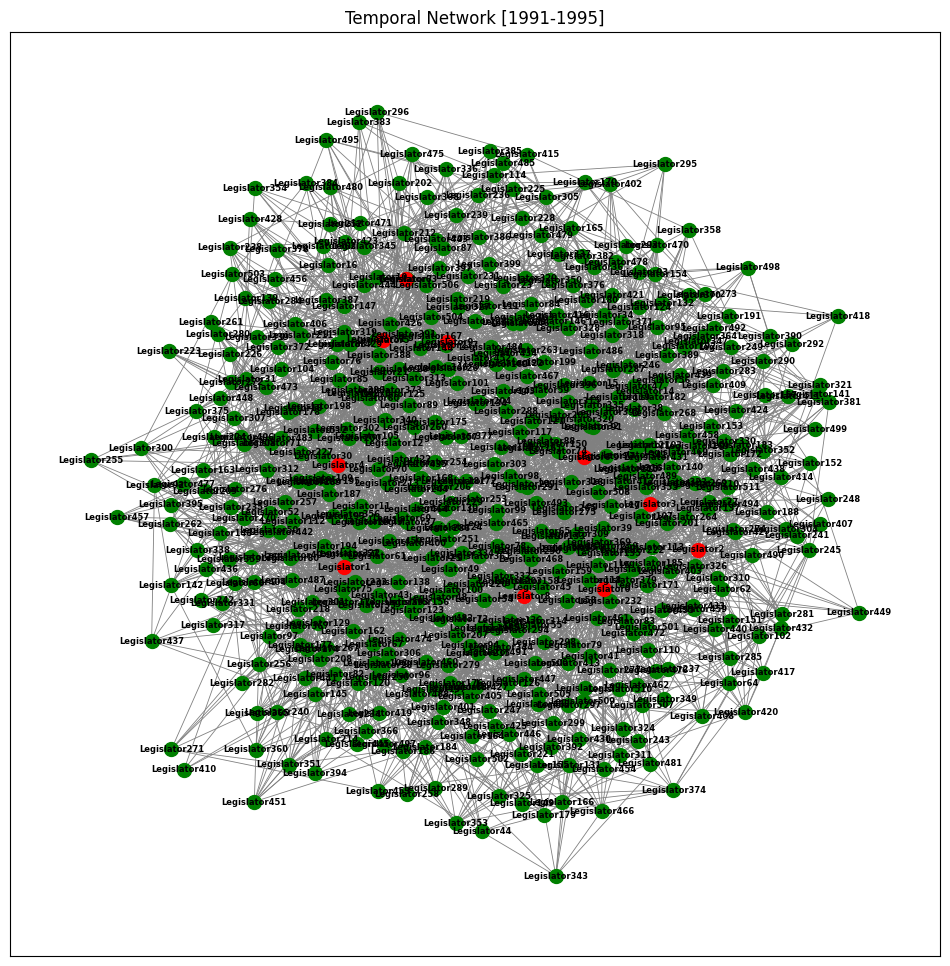

In [ ]:
convicted_nodes = [node for node, data in G.nodes(data=True) if 'Convicted' in data and data['Convicted'] == 1]
non_convicted_nodes = [node for node in G.nodes if node not in convicted_nodes]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, nodelist=non_convicted_nodes, node_color='green', node_size=100)
nx.draw_networkx_nodes(G, pos, nodelist=convicted_nodes, node_color='red', node_size=100)

nx.draw_networkx_edges(G, pos, width=0.6, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=6, font_color='black', font_weight='bold')

plt.title('Temporal Network [1991-1995]')
plt.show()

In the subsequent step, we apply the **Fast Greedy Algorithm** for "Community Detection" to the constructed temporal network. The **Fast Greedy Algorithm** is a modularity optimization approach that aims to identify communities within a network. This algorithm operates by iteratively merging communities based on the maximization of modularity - a measure that quantifies the strength of the division of a network into distinct groups.

In [ ]:
communities = list(nx.community.greedy_modularity_communities(G, resolution = 2.0))

In [ ]:
for i, community_nodes in enumerate(communities):
    print(f"Community {i + 1} size: {len(community_nodes)}")

Community 1 size: 94
Community 2 size: 74
Community 3 size: 74
Community 4 size: 63
Community 5 size: 42
Community 6 size: 38
Community 7 size: 34
Community 8 size: 32
Community 9 size: 32
Community 10 size: 18
Community 11 size: 5
Community 12 size: 3
Community 13 size: 2
Community 14 size: 2


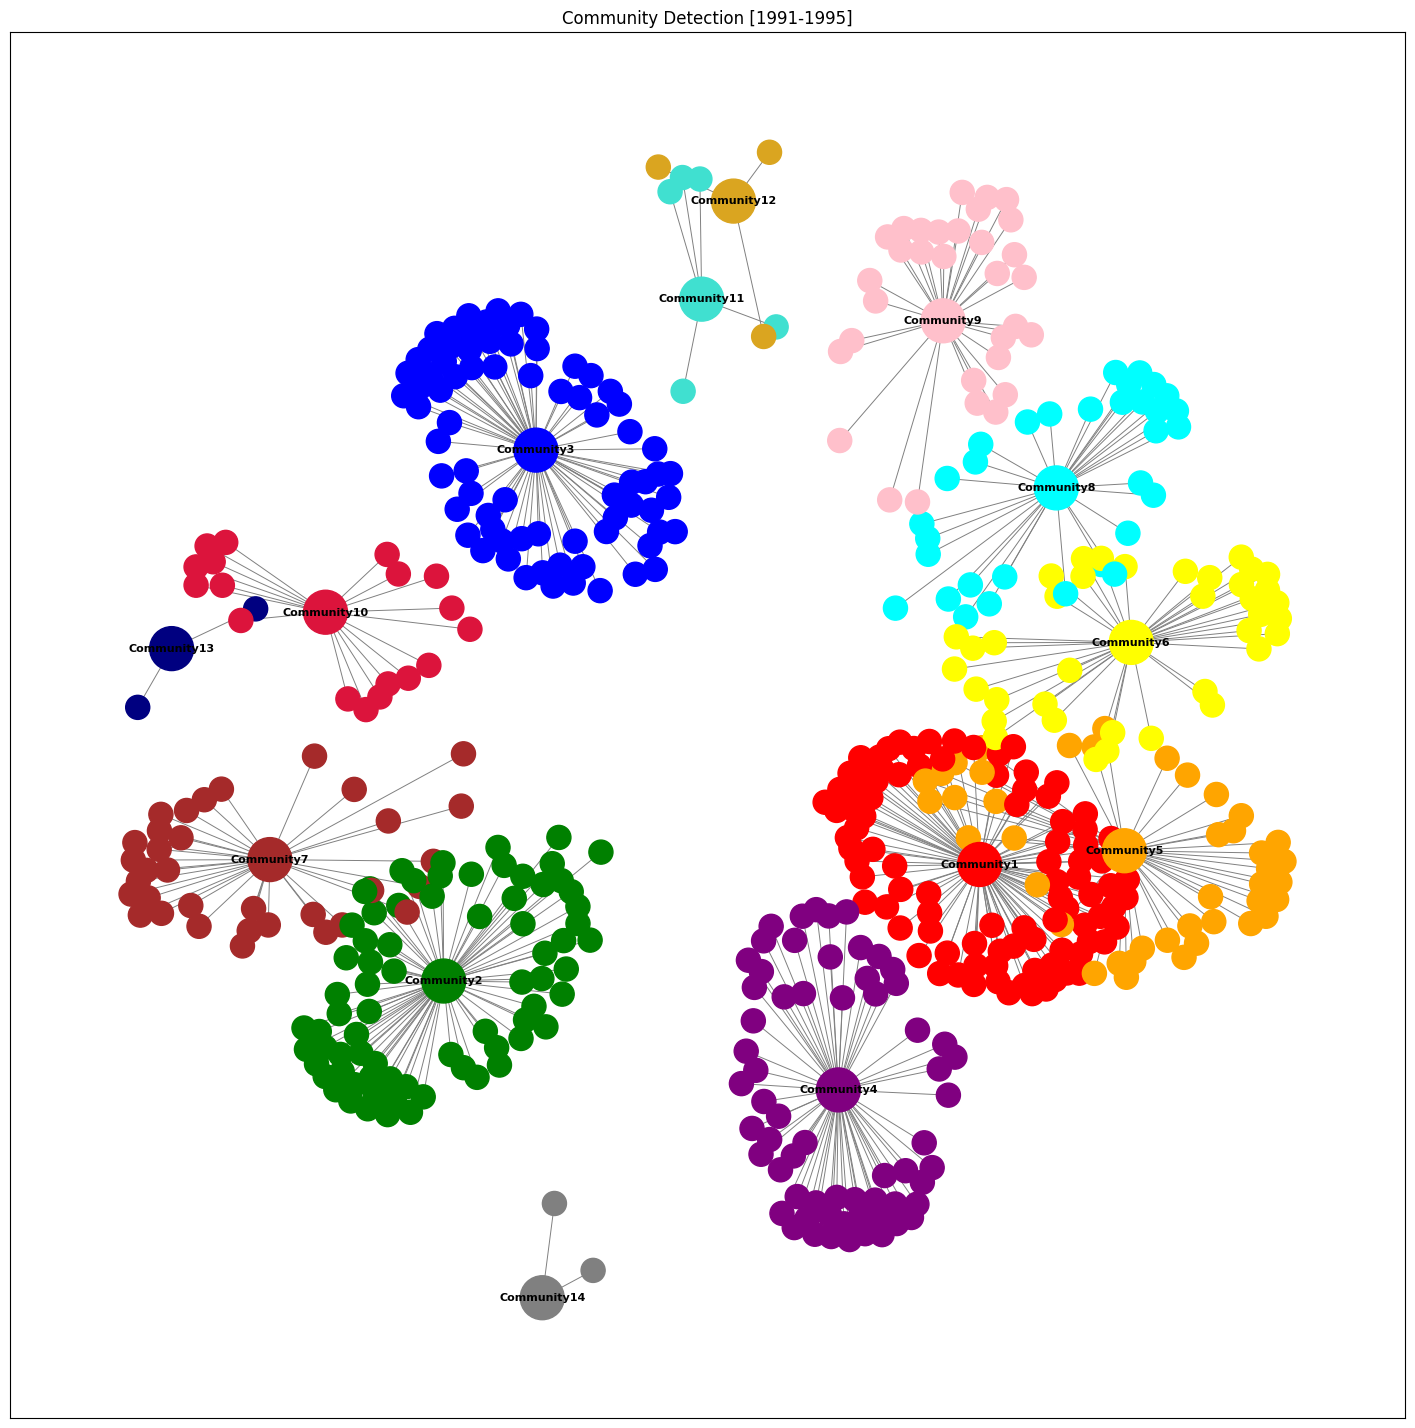

In [ ]:
result_set = set()
for i, community_nodes in enumerate(communities):
    community_id = f'Community{i+1}'
    result_set.update((node, community_id) for node in community_nodes)

G = nx.Graph()
G.add_edges_from(result_set)

for node in G.nodes:
    for i, community_nodes in enumerate(communities):
        community_id = f'Community{i+1}'
        if node in community_nodes:
            G.nodes[node]['Community'] = community_id

community_edges = nx.Graph()

for edge in G.edges:
    node1, node2 = edge
    community1 = G.nodes[node1].get('Community', 'DefaultCommunity')
    community2 = G.nodes[node2].get('Community', 'DefaultCommunity')

    if community1 != 'DefaultCommunity' and community2 != 'DefaultCommunity' and community1 != community2:
        community_edges.add_edge(community1, community2)

plt.figure(figsize=(18, 18))
pos = nx.spring_layout(G, seed=42, k=0.135)

legislator_nodes = [node for node in G.nodes if not node.startswith('Community')]
community_nodes = [node for node in G.nodes if node.startswith('Community')]

community_colors = {
    'Community1': 'red',
    'Community2': 'green',
    'Community3': 'blue',
    'Community4': 'purple',
    'Community5': 'orange',
    'Community6': 'yellow',
    'Community7': 'brown',
    'Community8': 'cyan',
    'Community9': 'pink',
    'Community10': 'crimson',
    'Community11' : 'turquoise',
    'Community12' : 'goldenrod',
    'Community13' : 'navy'
}

nx.draw_networkx_nodes(G, pos, nodelist=legislator_nodes, node_color=[community_colors.get(G.nodes[node].get('Community', 'DefaultCommunity'), 'gray') for node in legislator_nodes], node_size=300, label='Legislator')

nx.draw_networkx_nodes(G, pos, nodelist=community_nodes, node_color=[community_colors.get(node, 'gray') for node in community_nodes], node_size=1000, label='Community')

if community_edges.number_of_edges() > 0:
    nx.draw_networkx_edges(community_edges, pos, width=2.0, edge_color='black', style='dashed')

nx.draw_networkx_edges(G, pos, width=0.7, edge_color='gray')

labels = {node: node if node.startswith('Community') else '' for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color='black', font_weight='bold')

plt.title('Community Detection [1991-1995]')
plt.show()


In light of the inherent randomness in the generated data, we replicate the approach outlined in the referenced paper by introducing edges between communities. An observation from the analysis reveals an absence of connections among communities, a phenomenon likely attributed to the stochastic nature of the data. This lack of inter-community relations underscores the influence of randomness on the network's structure. Despite this inherent variability, the deliberate introduction of edges between communities allows for an exploration of potential connections that may arise in the context of the generated legislative network. This consideration underscores the importance of discerning between random patterns and meaningful relationships, contributing to a more comprehensive understanding of the network's dynamics.

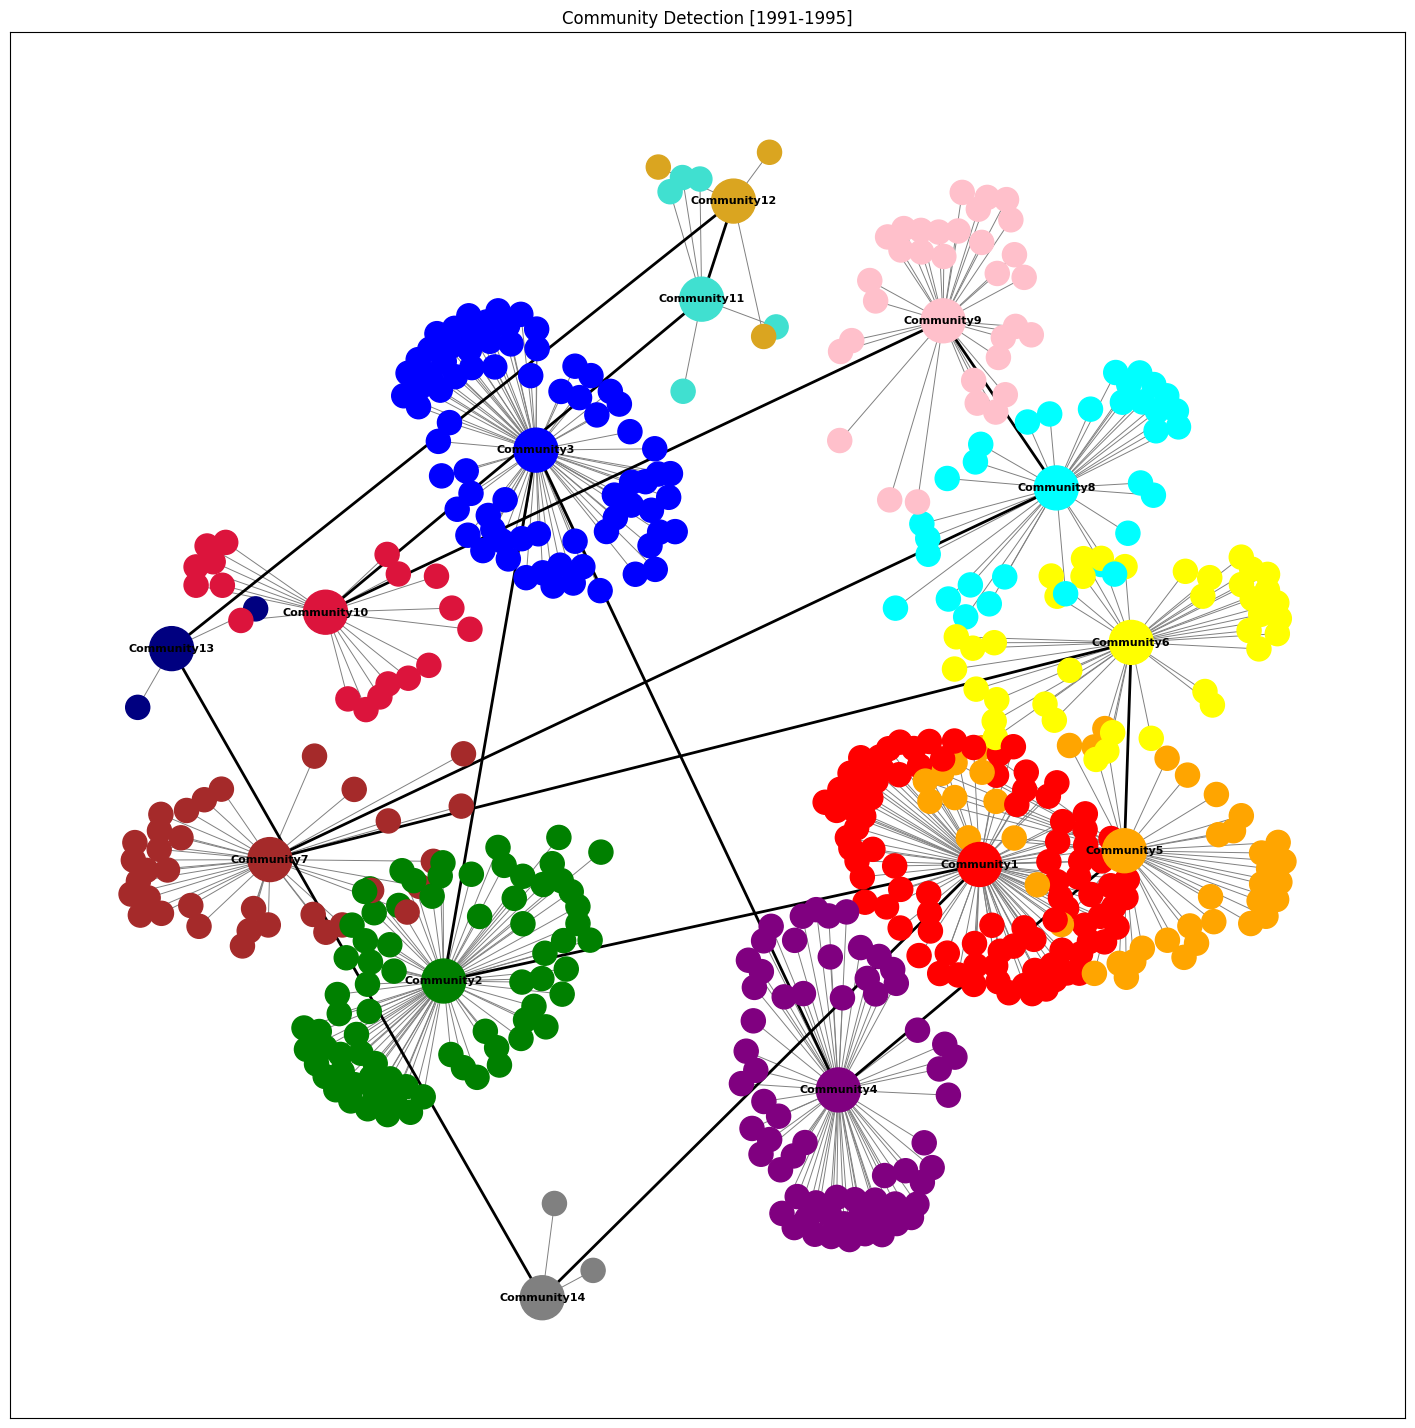

In [ ]:
result_set = set()
for i, community_nodes in enumerate(communities):
    community_id = f'Community{i+1}'
    result_set.update((node, community_id) for node in community_nodes)

G = nx.Graph()
G.add_edges_from(result_set)

for node in G.nodes:
    for i, community_nodes in enumerate(communities):
        community_id = f'Community{i+1}'
        if node in community_nodes:
            G.nodes[node]['Community'] = community_id

community_edges = nx.Graph()

for i in range(1, len(communities) + 1):
    community_edges.add_edge(f'Community{i}', f'Community{i%len(communities)+1}')

plt.figure(figsize=(18, 18))
pos = nx.spring_layout(G, seed=42, k=0.135)

legislator_nodes = [node for node in G.nodes if not node.startswith('Community')]
community_nodes = [node for node in G.nodes if node.startswith('Community')]

community_colors = {
    'Community1': 'red',
    'Community2': 'green',
    'Community3': 'blue',
    'Community4': 'purple',
    'Community5': 'orange',
    'Community6': 'yellow',
    'Community7': 'brown',
    'Community8': 'cyan',
    'Community9': 'pink',
    'Community10': 'crimson',
    'Community11' : 'turquoise',
    'Community12' : 'goldenrod',
    'Community13' : 'navy'
}

nx.draw_networkx_nodes(G, pos, nodelist=legislator_nodes, node_color=[community_colors.get(G.nodes[node].get('Community', 'DefaultCommunity'), 'gray') for node in legislator_nodes], node_size=300, label='Legislator')

nx.draw_networkx_nodes(G, pos, nodelist=community_nodes, node_color=[community_colors.get(node, 'gray') for node in community_nodes], node_size=1000, label='Community')

nx.draw_networkx_edges(G, pos, width=0.7, edge_color='gray')

labels = {node: node if node.startswith('Community') else '' for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color='black', font_weight='bold')


nx.draw_networkx_edges(community_edges, pos, width=2.0, edge_color='black')

plt.title('Community Detection [1991-1995]')
plt.show()


**Corruption Prediction Model**

For the **Corruption Prediction Model**, we adhere to the methodology outlined in the referenced paper, following a stepwise approach:

1. Create a subgraph: We create a subgraph derived from the legislators' network generated by matrix 𝑾(t). This subgraph exclusively includes congresspeople with convictions and their immediate neighbors, encompassing both incoming and outgoing edges. \

2. Convert the network resulting from the subgraph to undirected one : We convert the resulting subgraph into an undirected network. As part of this transformation, all existing links between nodes labeled as convicted are removed. \

3. Apply the link prediction technique on the network : We implement a link prediction technique on the modified network. The link prediction process is instrumental in forecasting potential connections that may emerge within the network. \

4. Take the top 𝑛 link predictions whose source node is convicted and label their target nodes as convicted ones as well.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import jaccard_score
from sklearn.metrics import pairwise_distances
from itertools import combinations

In [ ]:
def convert_to_undirected(graph):
  undirected_graph = graph.to_undirected()
  return undirected_graph

In [ ]:
def label_convicted_nodes(graph, predictions, top_n=10):
    convicted_nodes = [node for node, data in graph.nodes(data=True) if 'Convicted' in data and data['Convicted'] == 1]

    top_predictions = sorted(predictions, key=lambda x: x[2], reverse=True)[:top_n]
    predicted_links = [(source, target) for source, target, _ in top_predictions]

    for node in convicted_nodes:
        neighbors = list(graph.neighbors(node))
        for neighbor in neighbors:
            if (node, neighbor) in predicted_links or (neighbor, node) in predicted_links:
                graph.nodes[neighbor]['Convicted'] = 1

In [ ]:
# We create temporal networks for the 6 intervals :

Network_1991_1995 = create_temporal_network(weight_matrices_1991_1995, legislators_1991_1995)
Network_1996_2000 = create_temporal_network(weight_matrices_1996_2000, legislators_1996_2000)
Network_2001_2005 = create_temporal_network(weight_matrices_2001_2005, legislators_2001_2005)
Network_2006_2010 = create_temporal_network(weight_matrices_2006_2010, legislators_2006_2010)
Network_2011_2015 = create_temporal_network(weight_matrices_2011_2015, legislators_2011_2015)
Network_2016_2020 = create_temporal_network(weight_matrices_2016_2020, legislators_2016_2020)

In [ ]:
def get_convicted_legislators(legislators):
  return [legislator for legislator in legislators if legislator['Convicted'] == 1]

In [ ]:
# We get the convicted legislators from each interval :

convicted_legislators_1991_1995 = get_convicted_legislators(legislators_1991_1995)
convicted_legislators_1996_2000 = get_convicted_legislators(legislators_1996_2000)
convicted_legislators_2001_2005 = get_convicted_legislators(legislators_2001_2005)
convicted_legislators_2006_2010 = get_convicted_legislators(legislators_2006_2010)
convicted_legislators_2011_2015 = get_convicted_legislators(legislators_2011_2015)
convicted_legislators_2016_2020 = get_convicted_legislators(legislators_2016_2020)

*Local predictors:* Our corruption prediction model leverage information from the neighborhoods of source and target nodes. Examples of these local predictors include [Cosine, Maximum and Minimum Overlap, NMeasure, and Pearson]. These measures analyze the local context of nodes, taking into account shared neighbors and connections within their immediate network vicinity.

*Global predictors:* Focus on evaluating the relationship between source and target nodes based on measures that consider their overall network connectivity, even in the absence of shared neighbors. Examples of global predictors in our model include [Katz, RootedPageRank]. These measures provide a more comprehensive assessment of how nodes may be interrelated throughout the entire network, contributing valuable insights beyond the confines of their immediate local neighborhoods.

The link_prediction_Cosine function Computes the cosine similarity matrix using the normalized adjacency matrix. This matrix reflects pairwise similarities between nodes based on their connection patterns.

In [ ]:
def link_prediction_Cosine(Graph):
    adjacency_matrix = nx.adjacency_matrix(Graph).todense()
    normalized_adjacency = normalize(adjacency_matrix, norm='l2', axis=1)
    cosine_similarity_matrix = cosine_similarity(normalized_adjacency)
    np.fill_diagonal(cosine_similarity_matrix, 0)
    return cosine_similarity_matrix

The link_prediction_NMeasure function Utilizes the Jaccard similarity metric to compute the NMeasure similarity matrix. The Jaccard similarity measures the ratio of the size of the intersection to the size of the union of two sets.

In [ ]:
def link_prediction_NMeasure(Graph):
  adjacency_matrix = nx.adjacency_matrix(Graph).todense()
  nmeasure_similarity = 1 - pairwise_distances(adjacency_matrix, metric = jaccard_score)
  np.fill_diagonal(nmeasure_similarity, 0)
  return nmeasure_similarity

The minimum_overlap_link_prediction function Retrieves the respective sets of neighbors for each node pair (node1, node2). Then it calculates the overlap by finding the length of the intersection between the sets of neighbors. The overlap represents the number of common neighbors between the two nodes.

In [ ]:
def minimum_overlap_link_prediction(graph):
    predicted_links = []

    for node1, node2 in combinations(graph.nodes(), 2):
        neighbors1 = set(graph.neighbors(node1))
        neighbors2 = set(graph.neighbors(node2))

        overlap = len(neighbors1.intersection(neighbors2))
        if overlap == 0:
            predicted_links.append((node1, node2))

    return predicted_links

The link_prediction_Peason function Computes the Pearson correlation similarity matrix using the adjacency matrix. The Pearson correlation coefficient measures the linear correlation between two variables (the connectivity patterns of nodes).

In [ ]:
def link_prediction_Pearson(Graph):
  adjacency_matrix = nx.adjacency_matrix(Graph).todense()
  pearson_similarity = 1 - pairwise_distances(adjacency_matrix, metric = 'correlation')
  np.fill_diagonal(pearson_similarity, 0)
  return pearson_similarity

The link_prediction_RootedPageRank function Computes the Rooted PageRank matrix using the formula involving the damping factor ('alpha'), the inverse of the identity matrix, and the adjacency matrix. This matrix reflects the imporance of nodes in the network, considering both direct and indirect connections.

In [ ]:
def link_prediction_RootedPageRank(Graph, alpha=0.85, max_iter=100):
    pagerank_dict = nx.pagerank(nx.Graph(Graph), alpha=alpha, max_iter=max_iter)
    adjacency_matrix = nx.adjacency_matrix(Graph).todense()

    rooted_pagerank_matrix = alpha * np.linalg.inv(np.identity(adjacency_matrix.shape[0]) - alpha * adjacency_matrix) @ np.array(list(pagerank_dict.values())).reshape(-1, 1)

    np.fill_diagonal(rooted_pagerank_matrix, 0)

    return rooted_pagerank_matrix

The link_prediction_Katz function Computes the Katz centrality scores for each node in the graph. Katz centrality measures the influence of a node by considering not only its direct connections but also the contributions from its neighbors, with diminishing importance as the distance increases.

In [ ]:
def link_prediction_Katz(Graph, alpha=0.005, beta = 1):
    return nx.katz.katz_centrality(Graph, alpha, beta)

In [ ]:
start_year = 1991
Network_1991_2020 = nx.Graph()
Weight_Matrices_Data = [weight_matrices_1991_1995, weight_matrices_1996_2000, weight_matrices_2001_2005, weight_matrices_2006_2010, weight_matrices_2011_2015, weight_matrices_2016_2020]
Legislators_Data = [legislators_1991_1995, legislators_1996_2000, legislators_2001_2005, legislators_2006_2010, legislators_2011_2015, legislators_2016_2020]

The function create_temporal_network_all constructs a comprehensive temporal network spanning the years 1991 to 2020 based on the provided lists of weight matrices (weight_matrices_list) and legislators (legislators_list). This overarching network is structured to encompass all intervals within the specified timeframe. Notably, the generated network incorporates distinct identifiers for legislators, denoted by appending the interval number to their original identifier. \

\
Subsequently, a subgraph is derived from this extensive network, focusing on nodes representing congresspeople with convictions and their immediate neighbors. This subgraph accounts for both incoming and outgoing edges, providing a localized perspective on the connections surrounding legislators who have faced convictions. The resulting subgraph is designed to enhance the resolution of the network around convicted individuals, facilitating a more nuanced analysis of their interactions and potential linkages with neighboring legislators.

In [ ]:
def create_temporal_network_all(weight_matrices_list, legislators_list):
    G = nx.Graph()

    for interval, (matrices, legislators) in enumerate(zip(weight_matrices_list, legislators_list), start=1):
        for key, weight_matrix in matrices.items():
            session_id, year = map(int, key.split('_'))

            max_indices = np.argmax(weight_matrix, axis=1)

            for i, max_index in enumerate(max_indices):
                if i != max_index:
                    source_legislator = f'Legislator{i}_{interval}'
                    target_legislator = f'Legislator{max_index}_{interval}'

                    if 'Convicted' in legislators[i] and 'Convicted' in legislators[max_index]:
                        G.add_node(source_legislator, Convicted=legislators[i]['Convicted'])
                        G.add_node(target_legislator, Convicted=legislators[max_index]['Convicted'])

                    G.add_edge(source_legislator, target_legislator, year=year, session_id=session_id, interval=interval)

    return G

In [ ]:
Temporal_Network_1991_2020 = create_temporal_network_all(Weight_Matrices_Data, Legislators_Data)
Convicted_Legislators_1991_2020 = [convicted_legislators_1991_1995, convicted_legislators_1996_2000, convicted_legislators_2001_2005, convicted_legislators_2006_2010, convicted_legislators_2011_2015, convicted_legislators_2016_2020]

In [ ]:
def create_subgraph(graph, convicted_nodes_list):
    subgraph = nx.Graph()

    for convicted_nodes in convicted_nodes_list:
        for node_data in convicted_nodes:

            node_id = node_data['ID']
            legislator_id = ''.join(filter(str.isdigit, node_id))
            interval = node_data['Interval']

            updated_node_id = f'Legislator{legislator_id}_{interval}'


            try:
                subgraph.add_node(updated_node_id, Convicted=node_data['Convicted'], YearOfService=node_data['YearOfService'])
            except Exception as e:
                print(f"Invalid node ID format: {node_id}")
                continue


            neighbors = list(graph.neighbors(updated_node_id))
            subgraph.add_nodes_from(neighbors)
            subgraph.add_edges_from([(updated_node_id, neighbor) for neighbor in neighbors])

    return subgraph

In [ ]:
convicted_subgraph = create_subgraph(Temporal_Network_1991_2020, Convicted_Legislators_1991_2020)

Once the subgraph has been confirmed as undirected, the subsequent step involves the application of link prediction models on this refined network. The objective is to predict potential connections between nodes, with a particular focus on links involving legislators who have faced convictions. After generating link predictions, the top 𝑛 predictions are selected, specifically those where the source node is marked as convicted.

In the labeling process, the target nodes associated with the selected link predictions are also designated as convicted. This strategic labeling aims to augment the predictive model with information about potential future convictions, inferred from the network structure and link prediction results. By incorporating the convicted status from the source nodes to the predicted target nodes, the model gains insights into the anticipated connections involving legislators with a history of convictions. This methodology provides a data-driven approach to identify and label potential future cases of corruption or financial crimes within the legislative network.

In [ ]:
undirected_convicted_subgraph = convert_to_undirected(convicted_subgraph)

In [ ]:
node_label_to_index = {node: index for index, node in enumerate(undirected_convicted_subgraph.nodes())}

cosine_similarity_matrix = link_prediction_Cosine(undirected_convicted_subgraph)
nmeasure_similarity = link_prediction_NMeasure(undirected_convicted_subgraph)
pearson_similarity = link_prediction_Pearson(undirected_convicted_subgraph)
min_overlap_similarity = minimum_overlap_link_prediction(undirected_convicted_subgraph)

In [ ]:
threshold = 0.5

edges = list(convicted_subgraph.edges())
predicted_links_cosine = [(source, target) for source, target in edges if cosine_similarity_matrix[node_label_to_index[source]][node_label_to_index[target]] > threshold]
predicted_links_nmeasure = [(source, target) for source, target in edges if nmeasure_similarity[node_label_to_index[source]][node_label_to_index[target]] > threshold]
predicted_links_pearson = [(source, target) for source, target in edges if pearson_similarity[node_label_to_index[source]][node_label_to_index[target]] > threshold]

ground_truth_convicted = [1 if node in convicted_subgraph.nodes else 0 for node in Temporal_Network_1991_2020.nodes()]

accuracy_cosine = accuracy_score(ground_truth_convicted, [1 if node in predicted_links_cosine else 0 for node in Temporal_Network_1991_2020.nodes()])
accuracy_nmeasure = accuracy_score(ground_truth_convicted, [1 if node in predicted_links_nmeasure else 0 for node in Temporal_Network_1991_2020.nodes()])
accuracy_Pearson = accuracy_score(ground_truth_convicted, [1 if node in predicted_links_pearson else 0 for node in Temporal_Network_1991_2020.nodes()])

In [ ]:
def label_top_n_predictions(predictions, similarity_matrix, n):
    return sorted(predictions, key=lambda x: similarity_matrix[node_label_to_index[x[0]]][node_label_to_index[x[1]]], reverse=True)[:n]


n = 5
top_n_predictions_cosine = label_top_n_predictions(predicted_links_cosine, cosine_similarity_matrix, n)
top_n_predictions_pearson = label_top_n_predictions(predicted_links_pearson, pearson_similarity, n)
top_n_predictions_nmeasure = label_top_n_predictions(predicted_links_nmeasure, nmeasure_similarity, n)


for source, target in top_n_predictions_cosine:
    undirected_convicted_subgraph.nodes[target]['Convicted'] = 1

for source, target in top_n_predictions_pearson:
    undirected_convicted_subgraph.nodes[target]['Convicted'] = 1

for source, target in top_n_predictions_nmeasure:
    undirected_convicted_subgraph.nodes[target]['Convicted'] = 1

In [ ]:
def calculate_accuracy(predicted_links, actual_links):
    true_positives = len(set(predicted_links).intersection(actual_links))
    false_positives = len(set(predicted_links) - set(actual_links))

    total_predictions = len(predicted_links)

    accuracy = true_positives / total_predictions if total_predictions > 0 else 0.0

    return accuracy

In [ ]:
links = list(Temporal_Network_1991_2020.edges())
accuracy_min_overlap = calculate_accuracy(min_overlap_similarity, links)

In [ ]:
Rooted_PageRank_similarity = link_prediction_RootedPageRank(undirected_convicted_subgraph, alpha=0.85, max_iter=100)

In [ ]:
Rooted_PageRank_similarity_flat = Rooted_PageRank_similarity.flatten()

predicted_links_rooted_pagerank = [
    (source, target)
    for source, target in edges
    if node_label_to_index[source] < len(Rooted_PageRank_similarity_flat)
    and node_label_to_index[target] < len(Rooted_PageRank_similarity_flat)
    and Rooted_PageRank_similarity_flat[node_label_to_index[source]] > threshold
    and Rooted_PageRank_similarity_flat[node_label_to_index[target]] > threshold
]

accuracy_rooted_pagerank = accuracy_score(
    ground_truth_convicted,
    [1 if node in predicted_links_rooted_pagerank else 0 for node in Temporal_Network_1991_2020.nodes()]
)

Accuracy (Rooted PageRank): 0.776153346328785


In [ ]:
katz_similarity = link_prediction_Katz(undirected_convicted_subgraph, alpha = 0.005, beta = 1)

In [ ]:
threshold = 0.04
predicted_labels = {pair: 1 if score > threshold else 0 for pair, score in katz_similarity.items()}
correct_predictions = sum(1 for pair, predicted_label in predicted_labels.items() if (pair, 1) in ground_truth_convicted or (pair, 0) in ground_truth_convicted)
print(correct_predictions)
accuracy_katz = correct_predictions / len(ground_truth_convicted)

0
Accuracy: 0.0


In [ ]:
def visualize_network(graph, title):
    plt.figure(figsize=(14, 14))
    pos = nx.spring_layout(graph, seed=42)

    convicted_nodes = [node for node, data in graph.nodes(data=True) if 'Convicted' in data and data['Convicted'] == 1]
    non_convicted_nodes = [node for node in graph.nodes if node not in convicted_nodes]

    nx.draw_networkx_nodes(graph, pos, nodelist=non_convicted_nodes, node_color='green', node_size=50)
    nx.draw_networkx_nodes(graph, pos, nodelist=convicted_nodes, node_color='red', node_size=50)

    nx.draw_networkx_edges(graph, pos, width=0.6, edge_color='gray', alpha=0.7)

    plt.title(title)
    plt.show()

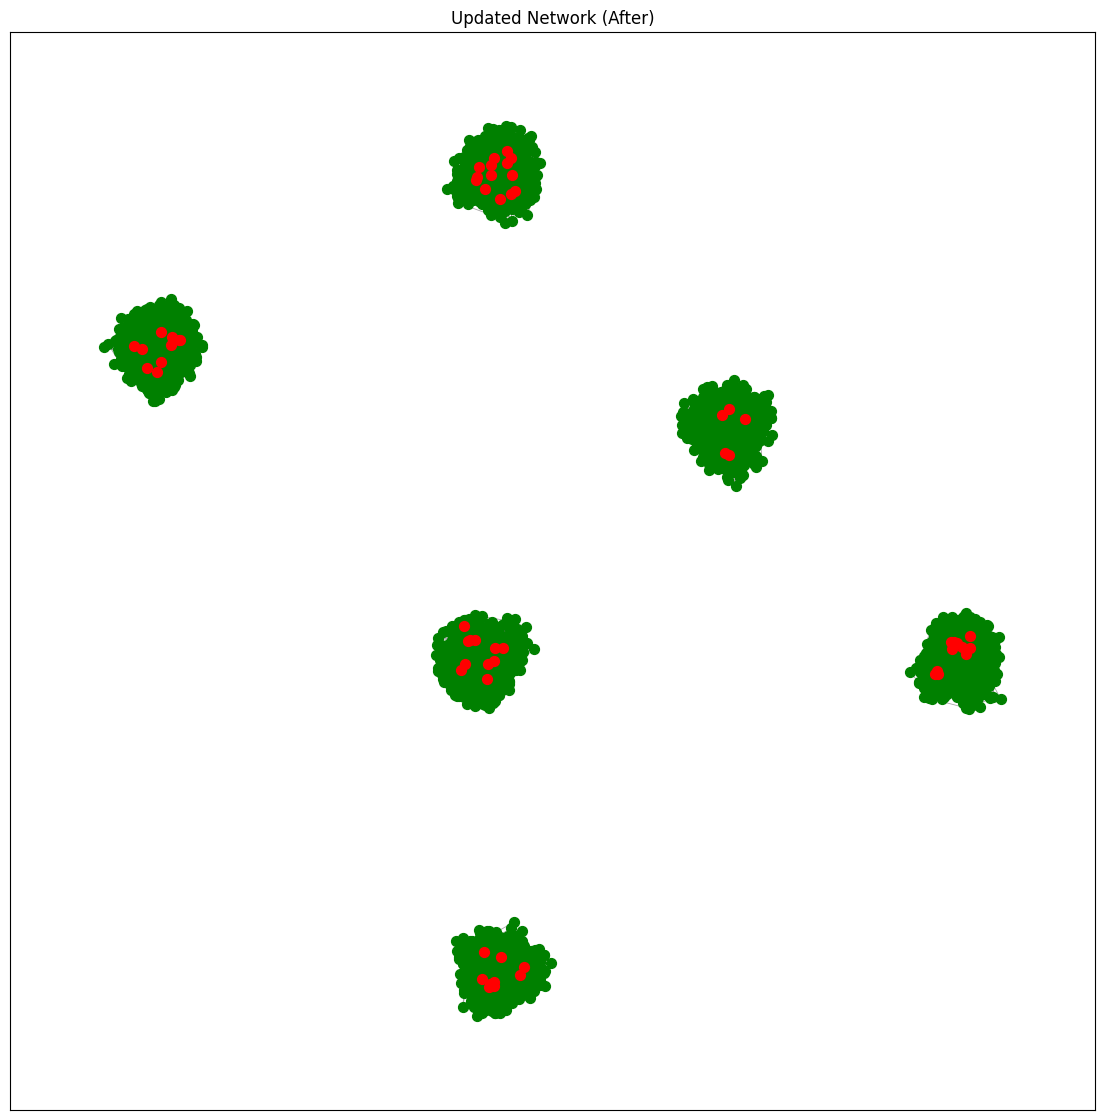

In [ ]:
n = 5
# One can test it with different link predictions here we visualized the network with the Cosine Similarity.

top_n_predictions_cosine = label_top_n_predictions(predicted_links_cosine, cosine_similarity_matrix, n)

#top_n_predictions_pearson = label_top_n_predictions(predicted_links_pearson, pearson_similarity, n)
#top_n_prediction_nmeasure = label_top_n_predictions(predicted_links_nmeasure, nmeasure_similarity, n)

for source, target in top_n_predictions_cosine:
    Temporal_Network_1991_2020.nodes[target]['Convicted'] = 1

    Temporal_Network_1991_2020.nodes[target]['Convicted'] = 1


    Temporal_Network_1991_2020.nodes[target]['Convicted'] = 1

visualize_network(Temporal_Network_1991_2020, 'Updated Network (After)')

**Analyzing Accuracies:**


In our final analysis of the link prediction models applied to the temporal network, we observed consistent and comparable accuracies for the Cosine, NMeasure, Pearson, and Rooted PageRank algorithms. These models demonstrated a level of predictive performance in line with each other, suggesting their efficacy in capturing underlying patterns within the network.

However, it is noteworthy that the MinOverlap prediction yielded an accuracy that is notably small, indicating potential limitations or challenges in predicting links using this specific algorithm within the context of our dataset. Furthermore, the Katz algorithm resulted in a 0 accuracy, indicating a substantial difficulty or inadequacy in predicting links based on its approach within our network.

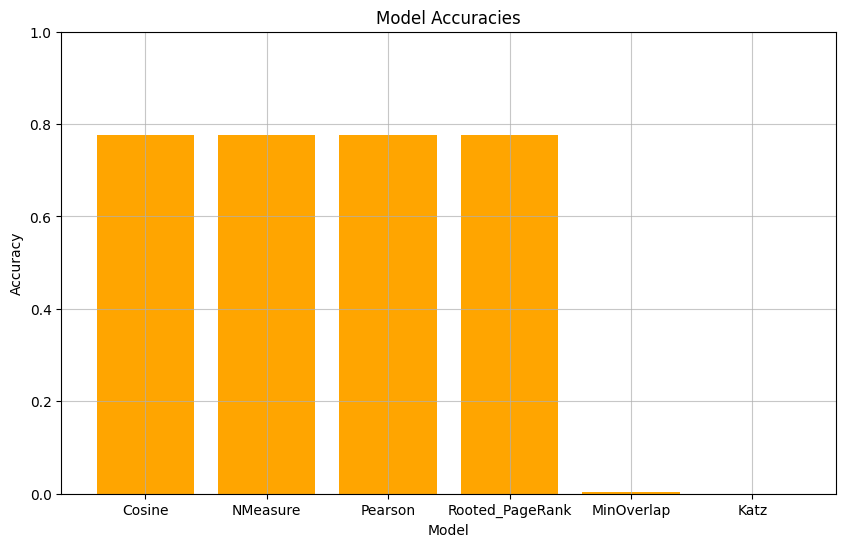

In [ ]:
accuracies = [accuracy_cosine, accuracy_nmeasure, accuracy_Pearson, accuracy_rooted_pagerank,accuracy_min_overlap, accuracy_katz]
model = ["Cosine", "NMeasure", "Pearson","Rooted_PageRank", "MinOverlap","Katz"]


plt.figure(figsize=(10, 6))


plt.bar(model, accuracies, color='orange')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.ylim(0, 1)
plt.grid(axis='both', linestyle='-', alpha=0.7)

plt.show()

**Final Remarks:**

In our final remarks, it is crucial to underscore the limitations and context surrounding the observed accuracies. The presented accuracy scores, while informative, should be interpreted with caution given the nature of the dataset. The data employed for this analysis is randomly generated, deviating from the complexities and intricacies inherent in real-world legislative networks.

The reliance on synthetic data introduces an element of variability, and the observed accuracies may not necessarily reflect the performance of the link prediction models in a real-world scenario. The inherent randomness in the data generation process, coupled with the deliberate introduction of edges between communities, underscores that these results should not be overinterpreted as indicative of the models' efficacy on authentic legislative datasets.

In essence, the accuracies derived from this analysis serve as a preliminary exploration rather than conclusive evidence. Subsequent evaluations with real-world legislative data would be essential for a more accurate and meaningful assessment of the link prediction models in practical applications. These results, while insightful, should be considered within the specific context of synthetic data experimentation and may not fully capture the intricacies of real legislative networks.